# Objetivos:

1. [Realizar pruebas estadísticas de estacionariedad y decide el tipo de transformación de la variable](#Objetivo-1)

2. [Calibra un modelo ARIMA-SARIMA basado en pruebas y gráficos de autocorrelaciones . Explica claramente el proceso de calibración y la razón de cómo va modificando los parámetros.](#Objetivo-2)

3. [Interpreta los coeficientes y su significancia estadística del modelo calibrado](#Objetivo-3)

4.  [Realiza una predicción de la variable utilizando el modelo calibrado.](#Objetivo-4)

In [118]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [119]:
from statsmodels.tsa.stattools import adfuller
import statsmodels.graphics.tsaplots as tsap
import statsmodels.tsa.arima.model as tsa_arima
import statsmodels.api as sm

In [120]:
df = pd.read_csv('./data/IGAE.csv')

In [121]:
df.isnull().values.any()

False

Reducimos el dataset a las variables de nuestro interes

In [122]:
df = df[['Periodo', 'Valor']]
df

,Periodo,Valor
0,2022/07,111.274552
1,2022/06,112.797501
2,2022/05,114.442424
3,2022/04,109.529866
4,2022/03,111.940152
...,...,...
350,1993/05,63.612900
351,1993/04,61.865984
352,1993/03,63.943249
353,1993/02,61.022521


Comprobamos el formato de los datos

In [123]:
df.dtypes

Periodo     object
Valor      float64
dtype: object

Configuramos el periodo en un formato de fecha para poder utilizarlo

In [124]:
df['Periodo'] = pd.to_datetime(df['Periodo'], infer_datetime_format = True)

Comprobamos el formato de los datos

In [125]:
df.dtypes

Periodo    datetime64[ns]
Valor             float64
dtype: object

In [126]:
df = df.sort_values(by=['Periodo'])
df

,Periodo,Valor
354,1993-01-01,60.407691
353,1993-02-01,61.022521
352,1993-03-01,63.943249
351,1993-04-01,61.865984
350,1993-05-01,63.612900
...,...,...
4,2022-03-01,111.940152
3,2022-04-01,109.529866
2,2022-05-01,114.442424
1,2022-06-01,112.797501


## Objetivo 1
### Realizar pruebas estadísticas de estacionariedad y decide el tipo de transformación de la variable

#### Indentificacion de estacionalidad

Primeramente obsevaremos el comportamiento de la serie

<AxesSubplot:xlabel='Periodo'>

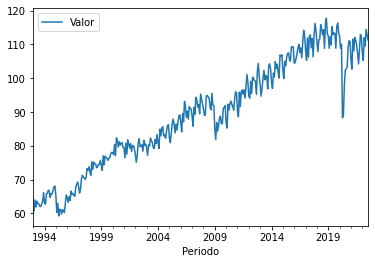

In [127]:
df.plot(x = 'Periodo', y = 'Valor')

Si bien al incio y al final de la serie podemos observar un comportamiento que pareciaera estacionario, la serie en su totalidad nos muestra un comportamiento con una tendencia creciente, y presencia de un patron estacionario.

#### Prueba de estacionalidad

In [128]:
def getStationary(df):
    stationary = df[['Periodo']]
    stationary['Seasonal difference log'] = np.log(df['Valor']).diff(12)
    stationary = stationary.dropna()
    return stationary

In [129]:
stationary = getStationary(df)
stationary

,Periodo,Seasonal difference log
342,1994-01-01,0.042483
341,1994-02-01,0.027647
340,1994-03-01,0.028476
339,1994-04-01,0.063042
338,1994-05-01,0.049767
...,...,...
4,2022-03-01,0.003661
3,2022-04-01,0.013414
2,2022-05-01,0.021001
1,2022-06-01,0.014522


<AxesSubplot:xlabel='Periodo'>

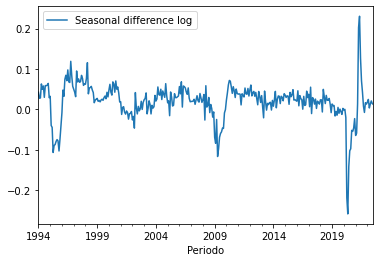

In [130]:
stationary.plot(x = 'Periodo', y = 'Seasonal difference log')

Resulta muy dificil determinar si es estacionaria unicamente observando la grafica

##### Prueba de Dicky-Fuller

Por defecto la prueba de Dicky-Fuller de statsmodels utiliza un lag de 12.

In [131]:
adfuller(stationary['Seasonal difference log'])[1]

0.0032602635688594645

Obtenemos que el p-value es de 0.003, con lo que cumple con la condicion de ser menor a 0.05, por lo que podemos afirmar que estacionaria, y podemos continuar con la calibracion del modelo

## Objetivo 2
### Calibra un modelo ARIMA-SARIMA basado en pruebas y gráficos de autocorrelaciones . Explica claramente el proceso de calibración y la razón de cómo va modificando los parámetros.

#### ACF

Los Metodos de ACF Y PACF regresan las correlaciones desde un lag 0 a n, por lo que se puede observar que en las primeras barrar la ausencia del horizonte.

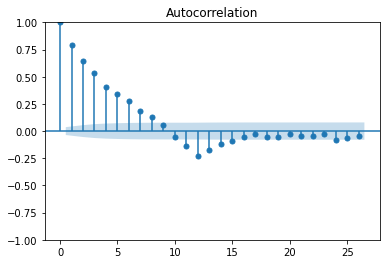

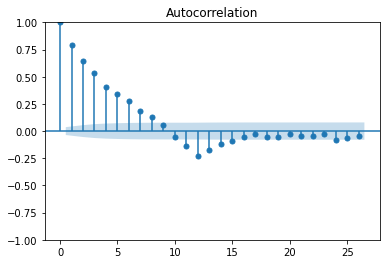

In [132]:
tsap.plot_acf(stationary['Seasonal difference log'], alpha = 0.5)

Podemos observar que los primeros 8 LAGs son positivos y significativos, decayendo de forma gradual. Lo cual nos indica que esta fuertemente correlacionado con sigo mismo del mes anterior hasta 8 meses previos (LAG 1-8).

#### PACF

/home/alt9193/.local/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


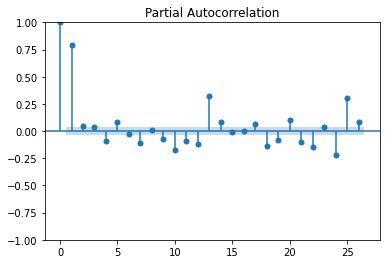

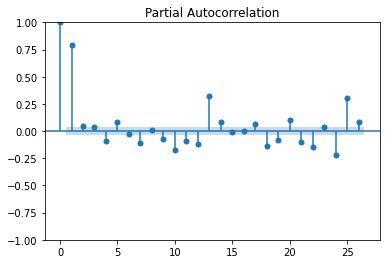

In [133]:
tsap.plot_pacf(stationary['Seasonal difference log'], alpha = 0.5)

Se puede observar que unicamente la primera autocorrelacion es positiva y significante y posteriormente decae.

#### Conclusiones

En base al analisis del ACF y PACF podemos concluir que estamos en presencia de un patron de un modelo AR(p), donde el numero de terminos esta determinado por los retrasos significativos de PACF. Por lo tanto partiremos de un modelo ARIMA con p=1 y q=0.

## Objetivo 3
### Interpreta los coeficientes y su significancia estadística del modelo calibrado

In [134]:
df

,Periodo,Valor
354,1993-01-01,60.407691
353,1993-02-01,61.022521
352,1993-03-01,63.943249
351,1993-04-01,61.865984
350,1993-05-01,63.612900
...,...,...
4,2022-03-01,111.940152
3,2022-04-01,109.529866
2,2022-05-01,114.442424
1,2022-06-01,112.797501


In [135]:
def getLogValor(df):
    return_df = df[['Periodo']]
    return_df['Log(Valor)'] = np.log(df['Valor'])
    return_df = return_df.dropna()
    return_df = return_df.set_index('Periodo')
    return return_df

In [136]:
sm_df = getLogValor(df)
sm_df

,Log(Valor)
Periodo,
1993-01-01,4.101116
1993-02-01,4.111243
1993-03-01,4.157996
1993-04-01,4.124970
1993-05-01,4.152816
...,...
2022-03-01,4.717964
2022-04-01,4.696197
2022-05-01,4.740072


In [137]:
# Variables de arima
p = 1
d = 0
q = 0

# Variables de sarima
P = 0
D = 1
Q = 0
periodos = 12

Estamos modelando el % de crecimiento anual sin considerar la primera diferencia de la serie, usando el primer termino para AR

In [138]:
model = sm.tsa.statespace.SARIMAX(sm_df['Log(Valor)'], order = (p,d,q), seasonal_order = (P,D,Q,periodos), simple_differencing=True).fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.15278D+00    |proj g|=  3.96162D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      2     19      1     0     0   2.722D-03  -2.153D+00
  F =  -2.1527837530770535     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/alt9193/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/alt9193/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


In [139]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                    DS12.Log(Valor)   No. Observations:                  343
Model:             SARIMAX(1, 0, 0)x(0, 0, 0, 12)   Log Likelihood                 738.405
Date:                            Sat, 26 Nov 2022   AIC                          -1472.810
Time:                                    02:31:51   BIC                          -1465.134
Sample:                                01-01-1994   HQIC                         -1469.752
                                     - 07-01-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8226      0.021     38.364      0.000       0.781       0.865
sigma2         0.0008   2.16e-05     36.449      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   1.51   Jarque-Bera (JB):              2929.18
Prob(Q):                              0.22   Prob(JB):                         0.00
Heteroskedasticity (H):               2.19   Skew:                            -0.38
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

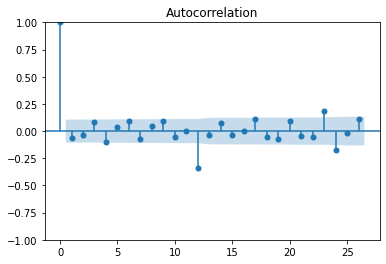

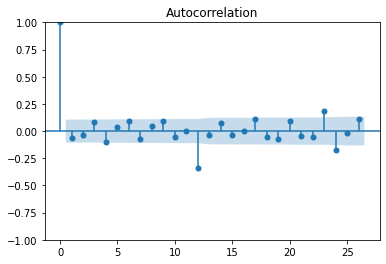

In [140]:
tsap.plot_acf(model.resid)

/home/alt9193/.local/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


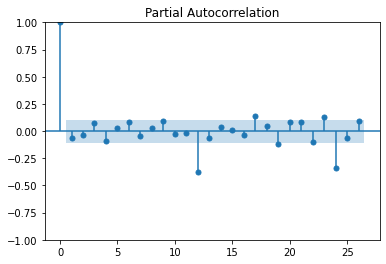

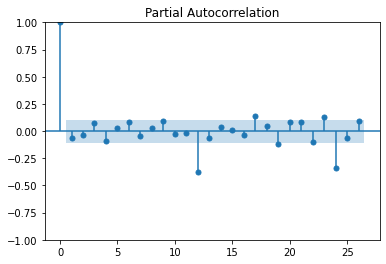

In [141]:
tsap.plot_pacf(model.resid)

El modelo no presenta ruido blanco por lo que tengo que agregar MA

In [142]:
# Variables de arima
p = 1
d = 0
q = 0

# Variables de sarima
P = 1
D = 1
Q = 1 # Originalmente Q=3, correcion en base a la retroalimentacion
periodos = 12

model = sm.tsa.statespace.SARIMAX(sm_df['Log(Valor)'], order = (p,d,q), seasonal_order = (P,D,Q,periodos), simple_differencing=True).fit()

/home/alt9193/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/alt9193/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.20527D+00    |proj g|=  3.81915D+00

At iterate    5    f= -2.21051D+00    |proj g|=  2.71757D+00

At iterate   10    f= -2.25493D+00    |proj g|=  1.44968D+00

At iterate   15    f= -2.25535D+00    |proj g|=  5.12693D-01

At iterate   20    f= -2.26336D+00    |proj g|=  5.74613D+00

At iterate   25    f= -2.31651D+00    |proj g|=  4.19567D-01

At iterate   30    f= -2.31886D+00    |proj g|=  8.16860D-01

At iterate   35    f= -2.32124D+00    |proj g|=  1.08693D-01

At iterate   40    f= -2.32722D+00    |proj g|=  2.82379D-01

At iterate   45    f= -2.32726D+00    |proj g|=  3.12690D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

In [143]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                      DS12.Log(Valor)   No. Observations:                  343
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 798.250
Date:                              Sat, 26 Nov 2022   AIC                          -1588.499
Time:                                      02:31:52   BIC                          -1573.148
Sample:                                  01-01-1994   HQIC                         -1582.385
                                       - 07-01-2022                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9841      0.013     76.783      0.000       0.959       1.009
ar.S.L12       0.1141      0.072      1.587      0.112      -0.027       0.255
ma.S.L12      -0.8720      0.055    -15.844      0.000      -0.980      -0.764
sigma2         0.0005   1.39e-05     38.322      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                  10.27   Jarque-Bera (JB):              5590.21
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.17   Skew:                            -1.70
Prob(H) (two-sided):                  0.00   Kurtosis:                        22.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

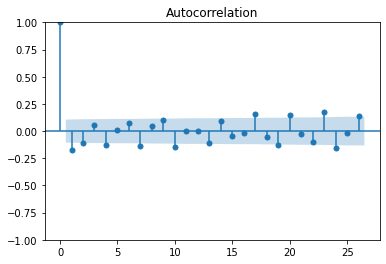

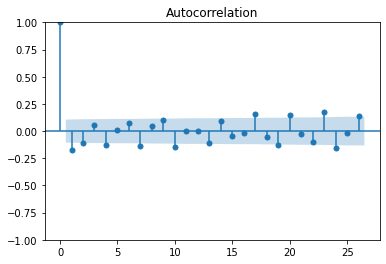

In [144]:
tsap.plot_acf(model.resid)

/home/alt9193/.local/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


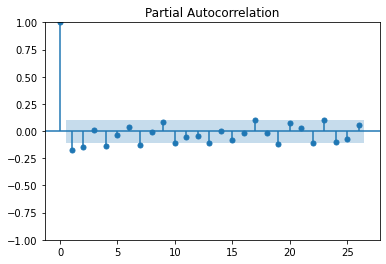

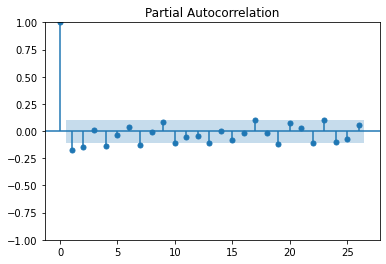

In [145]:
tsap.plot_pacf(model.resid)

In [146]:
sm.stats.acorr_ljungbox(model.resid, lags = [12])

,lb_stat,lb_pvalue
12,42.884042,0.000024


Analisando las graficas podemos observar que el modelo presenta ruido blanco, por lo que no es neceraio realizar mas cambios al modelo, por lo que podemos decir que hemos creado un modelo que estima el porcentaje de crecimiento anual (mes a mes) de la economia de Mexico.

El modelo en cuestion posee un termino autoregresivo y un termino auto regresivo seasonal. Ademas de estar configurado para tener una diferencia seasonal de 12 periodos (meses), lo que hace que para cada evalue el crecimiento de 12 entrada antes, por lo que para dar un ejemplo la entrada de abril del 2021 comparara el crecimiento con la entrada de abril del 2020.

# Nota

Para el ajuste del modelo se utilizo simple_differencing=True, ya que de tenerlo como falso no se veia reflejado ningun cambio en las graficas de ACF y PACF, sin embargo su uso para generar el modelo predictivo reduce el rango de la salida, haciendo imposible utilizar las predicciones, por lo que para las predicciones se utiliza un modelo con simple_differencing=False y los parametros obtenidos

In [157]:
model = sm.tsa.statespace.SARIMAX(sm_df['Log(Valor)'], order = (p,d,q), seasonal_order = (P,D,Q,periodos)).fit()

/home/alt9193/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/alt9193/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.99580D+00    |proj g|=  3.45637D+00

At iterate    5    f= -2.00056D+00    |proj g|=  2.47358D+00

At iterate   10    f= -2.04075D+00    |proj g|=  1.30242D+00

At iterate   15    f= -2.04113D+00    |proj g|=  4.45805D-01

At iterate   20    f= -2.04869D+00    |proj g|=  5.33644D+00

At iterate   25    f= -2.09845D+00    |proj g|=  2.41677D-01

At iterate   30    f= -2.09888D+00    |proj g|=  2.87482D-01

At iterate   35    f= -2.09905D+00    |proj g|=  1.30827D-02

At iterate   40    f= -2.10031D+00    |proj g|=  1.27536D+00

At iterate   45    f= -2.10554D+00    |proj g|=  1.13086D+00

At iterate   50    f= -2.10615D+00    |proj g|=  3.21004D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/alt9193/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Objetivo 4
### Realiza una predicción de la variable utilizando el modelo calibrado.

In [158]:
sm_df.tail()

,Log(Valor),forecast,Valor,exp forecast
2024-03-01,NaN,-0.003208,NaN,0.996797
2024-04-01,NaN,-0.003156,NaN,0.996849
2024-05-01,NaN,-0.003108,NaN,0.996897
2024-06-01,NaN,-0.003057,NaN,0.996948
2024-07-01,NaN,-0.003011,NaN,0.996994


In [159]:
from pandas.tseries.offsets import DateOffset
future=[sm_df.index[-1]+ DateOffset(months=x)for x in range(0,25)]

In [160]:
future=pd.DataFrame(index=future[1:],columns=sm_df.columns)

In [161]:
sm_df=pd.concat([sm_df, future])
sm_df.head()

,Log(Valor),forecast,Valor,exp forecast
1993-01-01,4.101116,NaN,60.407691,NaN
1993-02-01,4.111243,NaN,61.022521,NaN
1993-03-01,4.157996,NaN,63.943249,NaN
1993-04-01,4.12497,NaN,61.865984,NaN
1993-05-01,4.152816,NaN,63.6129,NaN


In [162]:
sm_df['Log(Valor)'] = sm_df['Log(Valor)'].astype('float64')
sm_df['Log(Valor)'].dtype

dtype('float64')

In [163]:
sm_df['forecast'] = model.predict(start = pd.to_datetime('2020-01-01'), end = pd.to_datetime('2024-07-01'), dynamic = True)


In [164]:
sm_df['Valor'] = np.exp(sm_df['Log(Valor)'])
sm_df['exp forecast'] = np.exp(sm_df['forecast'])

In [165]:
sm_df["2020-01-01":]

,Log(Valor),forecast,Valor,exp forecast
2020-01-01,4.721727,4.699926,112.362159,109.939011
2020-02-01,4.690055,4.673004,108.859169,107.018779
2020-03-01,4.700813,4.712204,110.036579,111.297216
2020-04-01,4.480443,4.696512,88.273807,109.564395
2020-05-01,4.488694,4.732595,89.005137,113.589981
...,...,...,...,...
2026-03-01,NaN,NaN,NaN,NaN
2026-04-01,NaN,NaN,NaN,NaN
2026-05-01,NaN,NaN,NaN,NaN
2026-06-01,NaN,NaN,NaN,NaN


<AxesSubplot:>

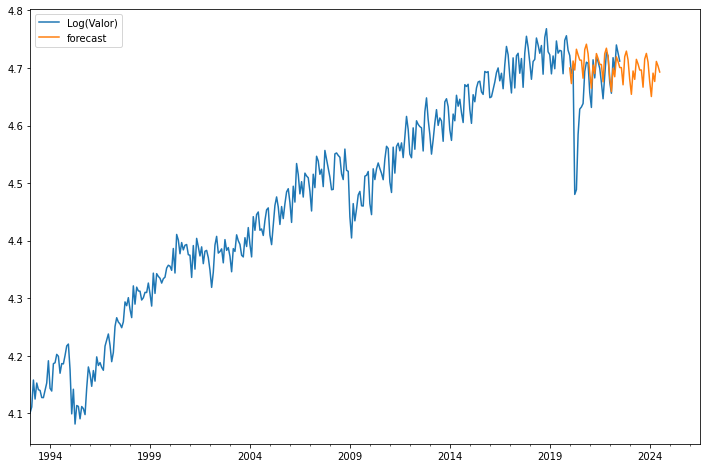

In [166]:
sm_df[['Log(Valor)', 'forecast']].plot(figsize=(12,8))

In [168]:
sm_df[sm_df["exp forecast"] > sm_df["Valor"]].head(4)

,Log(Valor),forecast,Valor,exp forecast
2020-03-01,4.700813,4.712204,110.036579,111.297216
2020-04-01,4.480443,4.696512,88.273807,109.564395
2020-05-01,4.488694,4.732595,89.005137,113.589981
2020-06-01,4.584236,4.722721,97.928293,112.473828


Como resultado final obtenemos una prediccion de los ultimos 37 meses previos, y de los proximos 24 meses. 

Apartir de la predicion hacia el pasado podemos observar que se comporta bastante apegado a la realidad la mayoria de tiempo, exceptuando los meses de abril, mayo, y junio del 2020. Si bien apesar de que el modelo no pudo predecir el impacto que tuvo el covid en esos meses, apesar de estar dentro de los datos de entrenamiento, si podemos observar que esos meses afectaron la tendencia de las predicciones futuras. 